# Analyse SEI Parameter Sensitivity Errors wrt Data

In [201]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os
from mpl_toolkits import mplot3d

eSOH_DIR = "./data/esoh_V/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/figures_sens/"
res_DIR = "./data/results_sens/"

%matplotlib widget

In [202]:
plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = (0.8, 0.8, 0.8)
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning']=False

In [203]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [204]:
def load_data(cell): 
    cell_no = f'{cell:02d}'
    dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe_0=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe['N']=dfe['Time'].astype(int)
    N =dfe.N.unique()
    print("Cycle Numbers:")
    print(*N, sep = ", ") 
    return cell_no,dfe,N

In [205]:
cell = 22
cell_no,dfe,N = load_data(cell)

Cycle Numbers:
0, 25, 93, 130, 168, 204, 245


In [206]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
# d_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,100]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [207]:
Temp_idx='0'
ksei_idx='0'
dsei_idx=''
sim_des = 'sens_accl'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.reset_index()
        dfl[i]=dft
        i+=1

In [208]:
dfl_m = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        # dft=dft.iloc[::20]
        dft=dft.reset_index()
        # if i>0:
        len_diff = dfe['N'].iloc[-1]-len(dft)+1
        print(len_diff)
        if len_diff>0:
            df_r1 = pd.concat([dft.iloc[[-1]]]*(len_diff), ignore_index=True)
            dft = pd.concat([dft,df_r1], ignore_index=True)
            dft['Cycle number']=np.arange(1,dfe['N'].iloc[-1]+2)
        dfl_m[i]=dft
        i+=1

-4
-4
-4
-4
-4
-4
-4
-4
-4


In [209]:
def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"kx")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Sim"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [210]:
k_sei_s = [f'{x:0.2f}' for x in k_sei]
d_sei_s = [str(x) for x in d_sei]
Temp_s = [str(x) for x in Temp]

# Plot eSOH vars

In [211]:
# esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
# esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
# for ev_num in range(len(esoh_vars)):
#     fig, ax = plt.subplots(1,1,figsize=(3,3))
#     col = ['k','g','b','r','c']
#     col_idx = [x // 2 +1 for x in range(-1,8)]
#     mar_idx = [x % 2 for x in range(-1,8)]
#     mar_idx[0]=2
#     mar = [u'v',u'P',u'x']
#     for k in range(len(dfl)):
#         ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[col_idx[k]],marker=mar[mar_idx[k]])
#         ax.set_title(split_long_string(esoh_vars[ev_num]))
#     # fig.legend(Temp_s, 
#     #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
#     plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [212]:
sadsada

NameError: name 'sadsada' is not defined

# Calculate RMSE

In [213]:
dfe["Capacity [A.h]"]=dfe["Cap"]
param = pybamm.LithiumIonParameters()
dfe["n_Li"]= 3600/param.F.value*(dfe["y_100"]*dfe["C_p"]+dfe["x_100"]*dfe["C_n"])
dfe["Loss of lithium inventory [%]"]=(1-dfe["n_Li"]/dfe["n_Li"][0])*100

In [214]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]#,"Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]#,"res","sei"]
rmse_final = []
rmse_final.append(esoh_vars_str)
for k in range(len(dfl)):
# for ev_num in range(len(esoh_vars)):
    # print([esoh_vars[ev_num]])
    dfl_t = dfl_m[k].iloc[N].reset_index()
    rmse_stats = []
    for ev_num in range(len(esoh_vars)):
    # for k in range(len(dfl)):
        # dfl_t = dfl_m[k].iloc[N].reset_index()
        rmse_t=((dfl_t[esoh_vars[ev_num]] - dfe[esoh_vars[ev_num]]) ** 2).mean() ** .5
        rmse_stats.append(rmse_t)
    print(rmse_stats)
    rmse_final.append(rmse_stats)

[0.016862486171141798, 0.02261484483979336, 0.10347458411120163, 0.1097085683544182, 0.0791318417699352, 1.6661497608165747]
[0.017942583006718443, 0.021712763127154092, 0.10347458576436004, 0.1097085683544182, 0.06926565501254012, 1.0231238091280255]
[0.01687672450587834, 0.022821063898724903, 0.10347458390486794, 0.1097085683544182, 0.08102027619139221, 1.7393550976634815]
[0.0440853191983949, 0.04220468584839676, 0.10347459460233449, 0.1097085683544182, 0.2010140296402808, 3.144129868156907]
[0.016879647701073114, 0.02284297720313316, 0.10347458389785788, 0.1097085683544182, 0.08121806830845384, 1.7467640210177173]
[0.10456464661312753, 0.1035899970817556, 0.10347460666371631, 0.1097085683544182, 0.5416793485833125, 10.280327451870008]
[0.016879955278111168, 0.022845181569707437, 0.1034745838976134, 0.1097085683544182, 0.08123793669348764, 1.747505801046354]
[0.14453696898229026, 0.14487274791407734, 0.10347461104578783, 0.1097085683544182, 0.7652992330397259, 14.905512797694172]
[0

In [215]:
x =  rmse_final
wanted = {a[0]: list(a[1:]) for a in zip(*x)}

In [216]:
# wanted

In [217]:
df_1 = pd.DataFrame.from_dict(wanted)
df_1.to_csv(res_DIR+'sens_rmse_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'.csv')

In [218]:
ssdsd

NameError: name 'ssdsd' is not defined

# Plot RMSE 

In [228]:
Temp_idx='0'
ksei_idx='_'
dsei_idx=''
sim_des = 'sens_rmse'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.reset_index()
        dft=dft.drop(columns=['index','Unnamed: 0'])
        dft['k_sei']=k_sei
        dft['d_sei']=d_sei[i]*np.ones(9)
        dfl[i]=dft
        i+=1

sens_rmse_T_0_k__D_0.csv
sens_rmse_T_0_k__D_1.csv
sens_rmse_T_0_k__D_2.csv
sens_rmse_T_0_k__D_3.csv
sens_rmse_T_0_k__D_4.csv
sens_rmse_T_0_k__D_5.csv
sens_rmse_T_0_k__D_6.csv
sens_rmse_T_0_k__D_7.csv
sens_rmse_T_0_k__D_8.csv


In [229]:
dfc = pd.concat([dfl[0],dfl[1]])
for i in range(2,9):
    dfc=pd.concat([dfc,dfl[i]])
dfc=dfc.reset_index()

In [235]:
dfc.to_csv(res_DIR+'sens_rmse_all'+'.csv')

## Plot eSOH error 3D

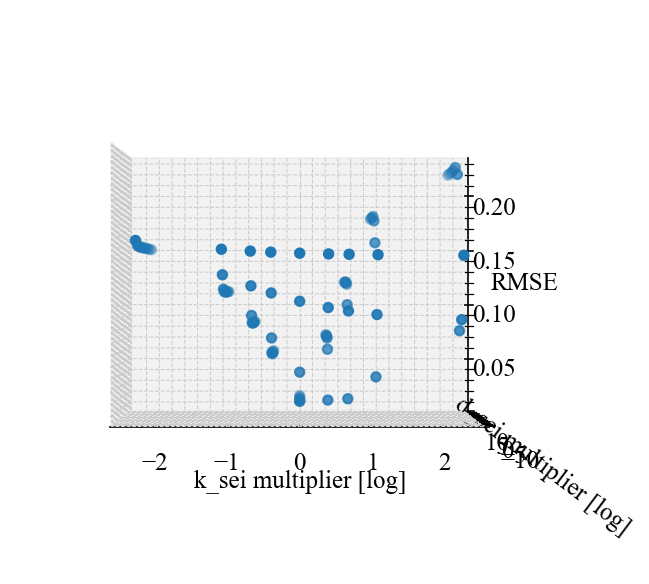

In [234]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X,Y = np.meshgrid(dfc['k_sei'],dfc['d_sei'])

ax.scatter3D(np.log(dfc['k_sei']),np.log(dfc['d_sei']),dfc['x_100'])
ax.set_xlabel('k_sei multiplier [log]')
ax.set_ylabel('d_sei multiplier [log]')
ax.set_zlabel('RMSE')
ax.view_init(0,-90)

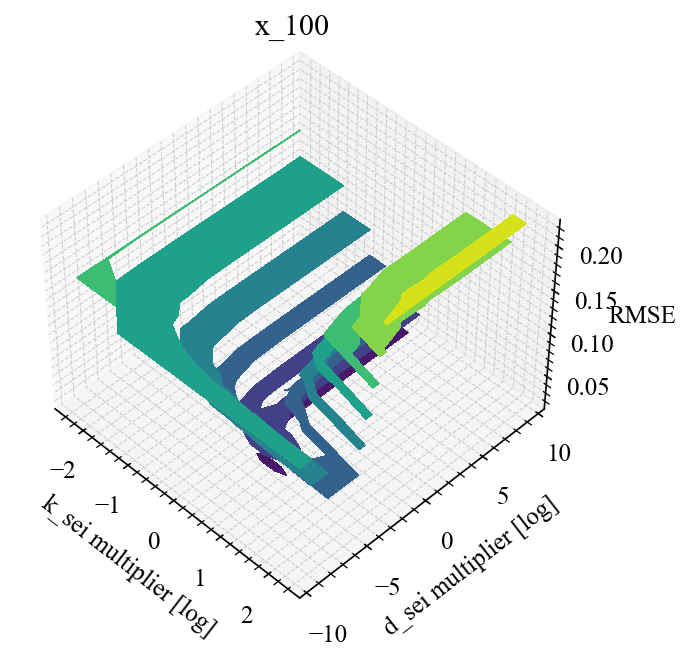

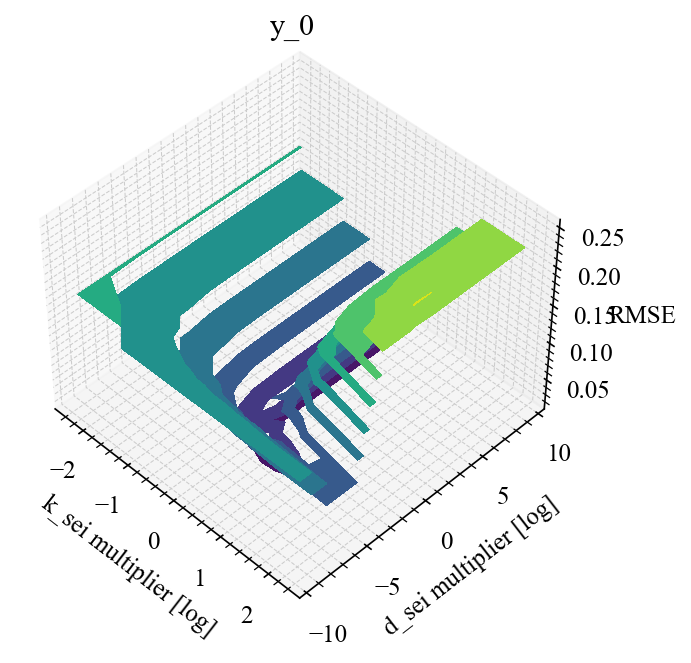

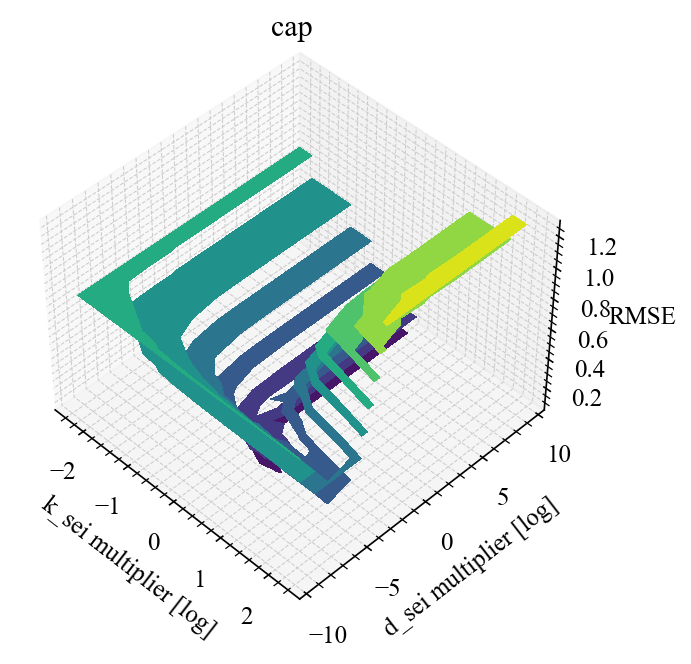

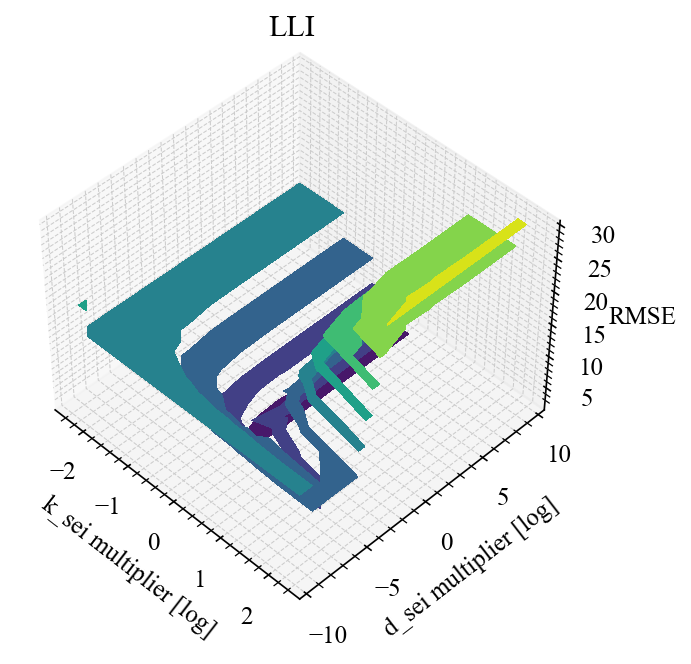

In [250]:
esoh_vars_str = ["x_100", "y_0", "cap", "LLI"]
ii = 0
for ii in range(len(esoh_vars_str)):
    ii
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # ax.contour3D(X, Y, Z, 50, cmap='binary')
    ax.tricontourf(np.log(dfc['k_sei']),np.log(dfc['d_sei']),dfc[esoh_vars_str[ii]])
    ax.set_xlabel('k_sei multiplier [log]')
    ax.set_ylabel('d_sei multiplier [log]')
    ax.set_zlabel('RMSE')
    ax.set_title(esoh_vars_str[ii])
    ax.view_init(45,-45)
    # ax.view_init(0,-90)
    plt.savefig(fig_DIR+'sens_rmse_cont_{0}'.format(esoh_vars_str[ii])+'.png')


## Plot eSOH 2D

In [ ]:
kk=0
# dfl[kk]

In [ ]:
# esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]#,"res","sei"]
# for ev_num in range(len(esoh_vars_str)):
#     fig, ax = plt.subplots(1,1,figsize=(3,3))

#     ax.scatter(d_sei,dfl[kk][esoh_vars_str[ev_num]])
#     ax.set_title(split_long_string(esoh_vars[ev_num]))
#     ax.set_xscale('log')
#     # fig.legend(Temp_s, 
#     #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
#     plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'_rmse.png')